In [46]:
import numpy as np
import matplotlib as plt
from matplotlib.image import imread
import matplotlib.pyplot as p
from scipy.signal import convolve2d
from scipy.signal import fftconvolve
from numpy.random import random
from os import listdir
from time import time
#from mnist import MNIST
%matplotlib inline

# TODO
- [X] Lave dense layers
- [X] Lave conv layers
- [X] Lave max-pooling
- [ ] cross entropy
- [-] Lave en test model (med test data)
  - [ ] Unit test. Narrow. Unit test. Narrow
- [ ] Evaluate 🎉
- [ ] Lav den rigtige model
- [ ] webcam blib blob
- [ ] diagram der viser convolution og backprop deraf (samt denselayers) 📌

In [47]:
a = random((200,200))
b = random((10,10))

aa = time()
convolve2d(a,b)
ba = time()
ab = time()
fftconvolve(a,b)
bb = time()

print("normal convolution time: ", (ba-aa)*1000)
print("fft convolution time:    ", (bb-ab)*1000)

normal convolution time:  101.78470611572266
fft convolution time:     11.531829833984375


In [48]:
image_src = imread("H_test.jpg")

In [49]:
image_src.shape

(200, 200, 3)

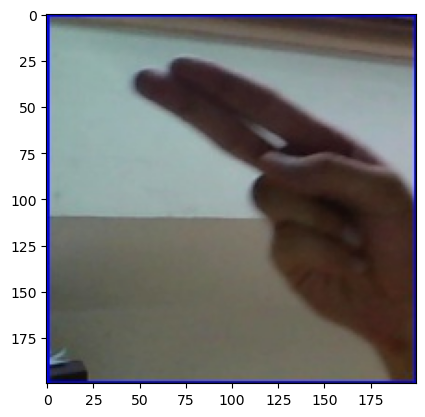

In [50]:
p.imshow(image_src)

In [51]:
def preprocess(image_src):
    image = np.array([n / 255. for n in image_src[:,:,0]]).reshape((200,200))

    # Define the Sobel filter kernels (constant kernels for edge detection)
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Perform convolution with the kernels to get the horizontal and vertical edges
    edges_x = fftconvolve(image, kernel_x, mode='valid')
    edges_y = fftconvolve(image, kernel_y, mode='valid')

    # Combine the horizontal and vertical edges to get the final edge image
    edges = np.sqrt(np.square(edges_x) + np.square(edges_y))

    # Normalize the edge image to a range between 0 and 1
    edges = edges / np.max(edges)
    return image[::2, ::2]

pp_shape = preprocess(image_src).shape
pp_shape

(100, 100)

In [139]:
def rvec(v): # Returns a vector as a single row matrix
    return v.reshape(1, np.prod(v.shape))

def cvec(v): # Returns a vector as a single column matrix
    return v.reshape(np.prod(v.shape), 1)


class DenseLayer:
    def __init__(self, i, o, lr = 0.01):
        self.lr = lr
        self.w = random((o, i)) # / i
        self.b = cvec(random(o)) # / i

    def predict(self, i):
        #print(self.w.shape, "*", cvec(i).shape, "+", self.b.shape)
        return np.matmul(self.w, cvec(i)) + self.b

    def backprop(self, i, dy):
        i = i.flatten()
        self.w -= np.matmul(cvec(dy), rvec(i)) * self.lr
        self.b -= dy * self.lr
        return np.matmul(self.w.T, dy)

In [123]:
print(np.matmul(np.zeros((5,3)), cvec(np.zeros((3,1)))))
print(cvec(np.zeros((3,1))))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]]


In [89]:
#np.matmul(rvec(np.array([1,2,3])), cvec(np.array([10,100])))

In [90]:
def rot180(mat):
    return np.rot90(mat, 2)

In [91]:
# input -> l1 (CNN) -> l2 (CNN) -> l3 -> cost
# target -> Δcost -> Δl3 -> Δl2 -> Δl1

# x = input matrix
# w = cnn filter
# Δy = gradient

class CNN:
    def __init__(self, filter_shape, lr=0.01):
        self.lr = lr
        self.filter = random(filter_shape) * 2 - 1

    def predict(self, i):
        return fftconvolve(i, self.filter, mode='same')
        # mode='same'

    #def predict(self, x):
    #    y = np.zeros_like(x)

    #    for i_row in range(0,self.filter.shape[0]):
    #        for i_col in range(0,self.filter.shape[1]):

    #            for j_row in range(0,x.shape[0]):
    #                for j_col in range(0,x.shape[1]):

    #                    k_row = j_row + i_row
    #                    k_col = j_col + i_col

    #                    if k_row >= y.shape[0] or k_col >= y.shape[1] or k_row < 0 or k_col < 0:
    #                        continue

    #                    y[j_row, j_col] += x[k_row, k_col] * self.filter[i_row, i_col]
    #    return y

    def backprop(self, x, Δy):
        dldf = np.zeros(self.filter.shape)

        for i_row in range(0,self.filter.shape[0]):
            for i_col in range(0,self.filter.shape[1]):

                for j_row in range(0,x.shape[0]):
                    for j_col in range(0,x.shape[1]):

                        k_row = j_row + i_row
                        k_col = j_col + i_col

                        if k_row >= Δy.shape[0] or k_col >= Δy.shape[1] or k_row < 0 or k_col < 0:
                            continue

                        dldo = Δy[k_row, k_col]
                        dodf = x[j_row, j_col]

                        dldf[i_row, i_col] += dldo * dodf
                        #print(f"f[{i_row},{i_col}] += Δy[{k_row},{k_col}] * x[{j_row},{j_col}]")

        self.filter -= dldf * self.lr
        #d = fftconvolve(x, Δy)
        #assert len(x.shape) == 2
        #assert len(Δy.shape) == 2
        #assert len(d.shape) == 2
        #self.filter -= d[0:self.filter.shape[0], 0:self.filter.shape[1]] * self.lr
        #return fftconvolve(rot180(self.filter), Δy, mode='same')
        return fftconvolve(self.filter, Δy, mode='same')

In [92]:
def conv_unit_test():
    x = np.array([
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ])
    f = np.array([
        [1,2],
        [3,4]
    ])

    y1 = fftconvolve(x, f)
    y2 = np.zeros_like(x)

    for i_row in range(0,f.shape[0]):
        for i_col in range(0,f.shape[1]):

            for j_row in range(0,x.shape[0]):
                for j_col in range(0,x.shape[1]):

                    k_row = j_row + i_row
                    k_col = j_col + i_col

                    if k_row >= y2.shape[0] or k_col >= y2.shape[1] or k_row < 0 or k_col < 0:
                        continue

                    y2[j_row, j_col] += x[k_row, k_col] * f[i_row, i_col]


    print(y1)
    print(y2)

conv_unit_test()

[[ 1.  4.  7.  6.]
 [ 7. 23. 33. 24.]
 [19. 53. 63. 42.]
 [21. 52. 59. 36.]]
[[37 47 21]
 [67 77 33]
 [23 26  9]]


In [93]:
# x =
# [a,b,c,d]
# [e,f,g,h]
# [i,j,k,l]
#
# f =
# [1,2]
# [3,4]
#
# y =
# [a*1+b*2+e*3+f*4, b*1+c*2+f*3+g*4, c*1+d*2+g*3+h*4]


def cnn_unit_test():
    test_cnn = CNN((2,2), 0.0001)
    test_cnn_2 = CNN((2,2), 0.0001)
    #filter_target = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
    filter_target = np.array([[1,2],[-3,-4]])
    #test_target = random((2,3)) * 2 - 1

    #print(test_cnn.filter)

    for n in range(10000):
        i = random((5,5)) * 2 - 1
        test_target = fftconvolve(i, filter_target, mode='same')
        test_target = fftconvolve(test_target, filter_target, mode='same')
        l1o = test_cnn.predict(i)
        d2 = test_cnn_2.backprop(l1o, test_cnn_2.predict(l1o) - test_target)
        test_cnn.backprop(i, d2)
        #print("+--" * 20)
    
    #print(abs(test_cnn.predict(i) - test_target).sum()/(10*8))
    #print(test_target)
    #print(test_cnn.predict(i))
    print(test_cnn.filter)
    print(test_cnn_2.filter)

cnn_unit_test()

KeyboardInterrupt: 

In [ ]:
class MaxPool:
    def __init__(self, shape, scale):
        self.shape = shape
        self.scale = scale

    def predict(self, i):
        r = int(self.shape[0]/self.scale)
        c = int(self.shape[1]/self.scale)
        s = self.scale
        o = np.zeros((r, c))

        for row in range(0, r):
            for col in range(0, c):
                i_ = i[row*s:row*s+s, col*s:col*s+s]

                o[row,col] = i_.max()
        return o
    
    def backprop(self, i, dy):
        r = int(self.shape[0]/self.scale)
        c = int(self.shape[1]/self.scale)
        s = self.scale
        o = np.zeros(self.shape)
        assert dy.shape == (r, c)

        #for row in range(0,self.shape[0]):
        #    for col in range(0,self.shape[1]):
        #        o[row, col] = dy[int(row/self.scale), int(col/self.scale)]

        #for row in range(0,r):
        #    for col in range(0,c):
        #        o[row*self.scale, col*self.scale] = dy[row, col]

        for row in range(0, r):
            for col in range(0, c):
                if row*s+s > i.shape[0] or col*s+s > i.shape[1]:
                    continue
                i_ = i[row*s:row*s+s, col*s:col*s+s]
                m = i_.argmax()
                o[m] = dy[row, col]
        return o

    def n_out(self):
        return int(((self.shape[0]/self.scale) * (self.shape[1]/self.scale)))
    def out(self):
        return (int(self.shape[0]/self.scale), int(self.shape[1]/self.scale))

In [ ]:
class CNN_and_CO:
    def __init__(self, i_shape, layers, filters, lr=0.001):
        self.lr = lr # float
        self.i_shape = i_shape # (int, int)
        self.layers = layers # int
        self.filters = filters # int
        self.cnn_layers = [] # [CNN]
        self.pool_layers = [] # [MaxPool]
        self.shapes = [i_shape] # [(int, int)]
        self.cnn_cache = [] # [np.array]
        self.pool_cache = [] # [np.array]

        for i in range(layers):
            cnn = []
            pool = []

            for j in range(filters):
                cnn.append(CNN(i_shape, lr))
                pool.append(MaxPool(i_shape, 2))

            self.cnn_layers.append(cnn)
            self.pool_layers.append(pool)
            self.cnn_cache.append(None)
            self.pool_cache.append(None)
            i_shape = (self.pool_layers[-1][0].out()[0] * len(self.pool_layers[-1]), self.pool_layers[-1][0].out()[1])
            self.shapes.append(i_shape)

    def predict(self, i):
        for cnn, pool, i_shape, l in zip(self.cnn_layers, self.pool_layers, self.shapes, range(self.layers)):
            assert i_shape == i.shape
            self.cnn_cache[l] = i
            i = np.array([cnn.predict(i) for cnn in cnn]).reshape((i_shape[0] * len(cnn), i_shape[1]))
            self.pool_cache[l] = i
            i = np.array([pool.predict(i) for pool in pool]).reshape((pool[0].out()[0] * len(pool), pool[0].out()[1]))
        return i

    def backprop(self, i, dy):
        for cnn, pool, l in zip(self.cnn_layers[::-1], self.pool_layers[::-1], range(self.layers-1, -1, -1)):
            i_shape = self.shapes[l]
            assert i_shape == self.cnn_cache[l].shape
            #assert i_shape == self.pool_cache[l].shape

            pool_chunk = pool[0].out()[0]
            cnn_chunk =  int(self.shapes[l][0]/self.filters)

            #print(dy.shape)

            for cnn, pool, f in zip(cnn, pool, range(self.filters)):
                #print(self.pool_cache[l].shape)
                #print(f*pool_chunk,(f+1)*pool_chunk)
                dy = pool.backprop(self.pool_cache[l], dy[f*pool_chunk:(f+1)*pool_chunk,:])
                dy = cnn.backprop(self.cnn_cache[l], dy[f*cnn_chunk:(f+1)*cnn_chunk,:])

        return dy

    def n_out(self):
        return np.prod(self.shapes[-1])

    def out(self):
        return self.shapes[-1]

In [ ]:
def softmax(x):
    return np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum()

def delta_softmax(x, grad):
    return softmax(x) * (1 - softmax(x)) * grad

In [ ]:
train_path = "asl_alphabet_train/asl_alphabet_train/"
#test_path = "asl_alphabet_test/asl_alphabet_test/"

# Load training data from `train_path`
train_data = {}
for letter in listdir(train_path):
    path = train_path+letter+"/"
    train_data[letter] = [path+f for f in listdir(path)]

train_path = "mnist/trainingSet/trainingSet/"
#test_path = "mnist/testSet/testSet/"

# Load training data from `train_path`
mnist_train_data = {}
for letter in listdir(train_path):
    path = train_path+letter+"/"
    mnist_train_data[letter] = [path+f for f in listdir(path)]

In [ ]:
train_data.keys()

dict_keys(['G', 'U', 'R', 'J', 'K', 'W', 'H', 'M', 'space', 'B', 'Z', 'E', 'O', 'I', 'nothing', 'Q', 'F', 'V', 'P', 'Y', 'T', 'N', 'del', 'L', 'D', 'C', 'A', 'X', 'S'])

In [ ]:
labels = {}
i = 0
for n in train_data.keys():
    labels[n]=i
    i+=1

len(labels)

29

In [126]:
def onehot(n, len):
    o = np.zeros(len)
    o[n] = 1
    return cvec(o)

In [140]:
mnist_cnn = CNN((3, 3), 0.01)
mnist_maxpool = MaxPool((28, 28), 2)
mnist_out = DenseLayer(14*14, 10, 0.01)

bare = DenseLayer(28*28, 10, 0.01)

In [144]:
correct = 0
bare_correct = 0
for n in range(1000):
    for label in range(10):
        cnn_o = mnist_cnn.predict(imread(mnist_train_data[str(label)][n]))
        pool_o = mnist_maxpool.predict(cnn_o)
        
        out_o = mnist_out.predict(pool_o.flatten())
        out = softmax(out_o)

        dy = 2*(out-onehot(label, 10))
        dy = delta_softmax(out_o, dy)
        dy = mnist_out.backprop(pool_o.flatten(), dy)
        dy = mnist_maxpool.backprop(pool_o, dy.reshape([14,14]))
        dy = mnist_cnn.backprop(cnn_o, dy)

        if np.argmax(out_o) == label:
            correct += 1

        i = imread(mnist_train_data[str(label)][n]).reshape([28*28])
        bare_o = bare.predict(i)
        bare.backprop(i, delta_softmax(bare_o, 2*(softmax(bare_o)-onehot(label, 10))))
        if softmax(bare_o).argmax() == label:
            bare_correct += 1
        
    acc = correct/(10*n+1)*100
    acc2 = bare_correct/(10*n+1)*100
    print(f"{n} accuracy: {acc} | bare-accuracy: {acc2}", end="\r")

In [ ]:
filters = 3
#f_shapes = [(2,2), (8,8), (5,5), (3,3), (2,2)]
#l1 = [CNN(f_shapes[n], lr=0.001) for n in range(filters)]

In [ ]:
l1 = CNN_and_CO(pp_shape, 2, filters)
l3 = DenseLayer(l1.n_out(), len(labels), lr=0.01)

In [ ]:
def training_data(i):
    return [
        (
            preprocess(imread(train_data[letter][i])),
            onehot(labels[letter], len(labels)),
            letter
        ) for letter in train_data.keys()
    ]

In [103]:
i = 0
correct = 0

for n in range(0,50):
    for (img, target, letter) in training_data(n):
        s = img.shape

        l1o = l1.predict(img)
        l2o = np.tanh(l1o).flatten()
        l3o = l3.predict(l2o)
        out = softmax(l3o)

        if labels[letter] == out.argmax():
            correct += 1
        
        dc = 2*(out - target)
        d3 = l3.backprop(l2o, delta_softmax(l3o, dc))
        d2 = (-l2o**2 + 1) * d3
        d1 = l1.backprop(img, d2.reshape(l1.out()))

        i += 1
        print(n,"accuracy: ", correct/i*100, "% out:", out.argmax())#, "d3sum:", d3sum)

NameError: name 'training_data' is not defined

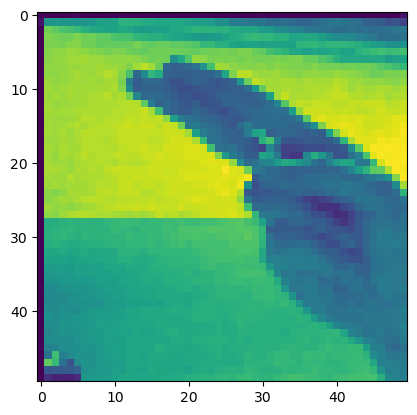

In [ ]:
p.imshow(imread("H_test.jpg")[::4,::4][:,:,0])

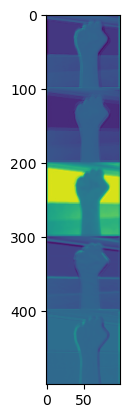

In [ ]:
o1 = np.array([l1.predict(img) for l1 in l1])
o1 = o1.reshape((s[0]*filters, s[1]))
p.imshow(o1)

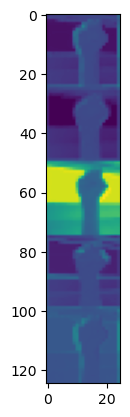

In [ ]:
o2 = l2.predict(o1)
p.imshow(o2)